In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import requests
from datetime import datetime, timedelta

# You can change this path to wherever you want in your Drive
drive_folder = "/content/drive/MyDrive/340-proj"
os.makedirs(drive_folder, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytesseract
!apt install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.7).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
#1: download pdf for given day onto drive
#2: access pdf
#3: scan text via OCR
#4: find embeddings vector in the text
#5: retrieve stock price the day of and the day before via API
#6: save vector and stock delta
#7: repeat for each day

In [ ]:
# Start and end dates
start_date = datetime.strptime("2012-07-11", "%Y-%m-%d")
end_date = datetime.strptime("2012-08-03", "%Y-%m-%d")

current_date = start_date

#while current_date <= end_date:
while current_date <= end_date:
    # Format the output filename
    filename = f"{current_date.strftime('%Y-%m-%d')}.pdf"
    output_file = os.path.join(drive_folder, filename)

    # Construct the URL
    url = f"https://static01.nyt.com/images/{current_date.strftime('%Y/%m/%d')}/nytfrontpage/scan.pdf"

    print(f"Downloading: {url} -> {output_file}")

    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(output_file, "wb") as f:
                f.write(response.content)
        else:
            print(f"Skipped (status code: {response.status_code})")
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")

    current_date += timedelta(days=1)

print("✅ All downloads finished and saved to Google Drive!")

Downloading: https://static01.nyt.com/images/2012/07/11/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-11.pdf
Downloading: https://static01.nyt.com/images/2012/07/12/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-12.pdf
Downloading: https://static01.nyt.com/images/2012/07/13/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-13.pdf
Downloading: https://static01.nyt.com/images/2012/07/14/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-14.pdf
Downloading: https://static01.nyt.com/images/2012/07/15/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-15.pdf
Downloading: https://static01.nyt.com/images/2012/07/16/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-16.pdf
Downloading: https://static01.nyt.com/images/2012/07/17/nytfrontpage/scan.pdf -> /content/drive/MyDrive/340-proj/2012-07-17.pdf
Downloading: https://static01.nyt.com/images/2012/07/18/nytfrontpage/scan.pdf -> /content/drive/MyDrive/

In [ ]:
!pip install ollama
!pip install colab-xterm
%load_ext colabxterm

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import ollama
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
!apt-get install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 66.2 MB/s eta 0:00:00


In [ ]:
import pdfplumber

start_date = datetime.strptime("2012-07-11", "%Y-%m-%d")
end_date = datetime.strptime("2023-08-27", "%Y-%m-%d")
current_date = start_date

data = []

while current_date <= end_date:
    filename = f"{current_date.strftime('%Y-%m-%d')}.pdf"
    filepath = os.path.join(drive_folder, filename)

    try:
        text = ""
        with pdfplumber.open(filepath) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"

        if text.strip():  # Only embed if some text was found
            embedding = ollama.embeddings(model='nomic-embed-text', prompt=text)
            data.append([current_date.strftime('%Y-%m-%d'), text, embedding])
            print(f"✅ Processed {filename}")
        else:
            print(f"⚠️ No extractable text in {filename}")
    except Exception as e:
        print(f"❌ Failed to process {filename}: {e}")

    try:
        os.remove(filepath)
        print(f"🗑️ Deleted {filename}")
    except Exception as e:
        print(f"⚠️ Could not delete {filename}: {e}")

    current_date += timedelta(days=1)

❌ Failed to process 2012-07-11.pdf: [Errno 2] No such file or directory: '/content/drive/MyDrive/340-proj/2012-07-11.pdf'
⚠️ Could not delete 2012-07-11.pdf: [Errno 2] No such file or directory: '/content/drive/MyDrive/340-proj/2012-07-11.pdf'
✅ Processed 2012-07-12.pdf
🗑️ Deleted 2012-07-12.pdf
✅ Processed 2012-07-13.pdf
🗑️ Deleted 2012-07-13.pdf
✅ Processed 2012-07-14.pdf
🗑️ Deleted 2012-07-14.pdf
✅ Processed 2012-07-15.pdf
🗑️ Deleted 2012-07-15.pdf
✅ Processed 2012-07-16.pdf
🗑️ Deleted 2012-07-16.pdf
✅ Processed 2012-07-17.pdf
🗑️ Deleted 2012-07-17.pdf
✅ Processed 2012-07-18.pdf
🗑️ Deleted 2012-07-18.pdf
✅ Processed 2012-07-19.pdf
🗑️ Deleted 2012-07-19.pdf
✅ Processed 2012-07-20.pdf
🗑️ Deleted 2012-07-20.pdf
✅ Processed 2012-07-21.pdf
🗑️ Deleted 2012-07-21.pdf
✅ Processed 2012-07-22.pdf
🗑️ Deleted 2012-07-22.pdf
✅ Processed 2012-07-23.pdf
🗑️ Deleted 2012-07-23.pdf
✅ Processed 2012-07-24.pdf
🗑️ Deleted 2012-07-24.pdf
✅ Processed 2012-07-25.pdf
🗑️ Deleted 2012-07-25.pdf
✅ Processed 20

Exception ignored in: <function _xla_gc_callback at 0x7ac55f4c0900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


✅ Processed 2012-08-03.pdf
🗑️ Deleted 2012-08-03.pdf


KeyboardInterrupt: 

In [ ]:
import csv
import json

output_path = '/content/drive/MyDrive/340-proj/output.csv'

with open(output_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'Text', 'Embedding'])  # Header row
    for date, text, embedding in data:
        writer.writerow([date, text, json.dumps(embedding['embedding'])])
print(data)

[['2012-07-12', 'C M Y K\nNxxx,2012-07-12,A,001,Bs-BK,E2\nLateEdition\nToday, sunny to partly cloudy,\nwarm, low humidity, high 88. To-\nnight,patchy clouds, a light breeze,\nlow 70. Tomorrow,sun and clouds,\nhigh 88. Weather map, Page A18.\nVOL.CLXI...No. 55,830 NEWYORK,THURSDAY, JULY12, 2012 $2.50\n©2012 The New York Times\nDRUGS DISPENSED RARE MUTATION\nBY DOCTORS COST MAY HELP FIGHT\nINSURERS DEARLY ON ALZHEIMER’S\nBIG MARKUPS FOR PILLS PREVENTIVE PROPERTIES\nEfforts to Draw Rein on New FindingAppears to\nPractice Are Stymied Back a Recent Push\nin Some States in Drug Research\nBy BARRY MEIER By GINA KOLATA\nandKATIE THOMAS\nA study of a rare gene muta-\nWhen a pharmacy sells the tion that protects people against\nheartburn drug Zantac, each pill Alzheimer’s disease provides the\ncosts about 35 cents. But doctors strongest evidence yet that ex-\ndispensing it to patients in their cessive levels of a normal brain\noffices have charged nearly 10 substance, beta amyloid, are a\ntimest

In [ ]:
#1 load in embeddings csv
#2 match date columns with the stock data
#3 feed that into neural network

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_embeddings.csv to cleaned_embeddings.csv


In [ ]:
spy = files.upload()

Saving DIA.csv to DIA.csv
Saving IEF.csv to IEF.csv
Saving IWM.csv to IWM.csv
Saving QQQ.csv to QQQ.csv
Saving SPY.csv to SPY.csv
Saving TLT.csv to TLT.csv
Saving VT.csv to VT.csv


In [ ]:
import pandas as pd
import ast

# Load embedding data
df_embed = pd.read_csv("embeddings.csv")
df_embed['Date'] = pd.to_datetime(df_embed['Date'])
df_embed['Embedding'] = df_embed['Embedding'].apply(ast.literal_eval)



In [ ]:
import os

# List of your tickers
tickers = ["SPY", "QQQ", "DIA", "TLT", "IEF", "VT", "IWM"]

# Loop through each ticker CSV and merge on date
for ticker in tickers:
    df_stock = pd.read_csv(f"{ticker}.csv")
    df_stock['timestamp'] = pd.to_datetime(df_stock['timestamp'])

    # Keep only date and percent_change
    df_change = df_stock[['timestamp', 'percent_change']].rename(columns={
        'timestamp': 'Date',
        'percent_change': ticker
    })

    # Merge with embedding dataframe
    df_embed = pd.merge(df_embed, df_change, on='Date', how='left')


In [ ]:
df_embed.head()


,Date,Text,Embedding,SPY,QQQ,DIA,TLT,IEF,VT,IWM
0,2013-01-26,CM ' K\n\n \n\n“All the News\nThat’s Fit to Pr...,"[0.9049825668334961, 1.9555302858352661, -2.92...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-27,CM ' K\n\n \n\n“All the News\nThat’s Fit to Pr...,"[-0.7186459302902222, 1.786336898803711, -3.25...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-28,CM\n\n \n\n“All the News\nThat’s Fit to Print”...,"[-0.7693108320236206, 1.1002334356307983, -3.0...",-0.11980,0.223881,0.021642,-0.364314,-0.206903,-0.388123,0.066711
3,2013-01-29,\n\n“All the News\nThat’s Fit to Print”\n\n \...,"[0.7794539928436279, 0.7138799428939819, -3.22...",0.39315,0.014892,0.418320,-0.552721,-0.150787,0.545490,0.055556
4,2013-01-30,\n\n“All the News\nThat’s Fit to Print”\n\n \...,"[-0.19204045832157135, 1.1853175163269043, -3....",-0.39161,-0.208457,-0.337571,-0.171013,0.056630,-0.135633,-1.199334


In [ ]:
df_embed_clean = df_embed.dropna()
df_embed_clean = df_embed_clean.drop(columns=["Text"])
df_embed_clean.head()

,Date,Embedding,SPY,QQQ,DIA,TLT,IEF,VT,IWM
2,2013-01-28,"[-0.7693108320236206, 1.1002334356307983, -3.0...",-0.119800,0.223881,0.021642,-0.364314,-0.206903,-0.388123,0.066711
3,2013-01-29,"[0.7794539928436279, 0.7138799428939819, -3.22...",0.393150,0.014892,0.418320,-0.552721,-0.150787,0.545490,0.055556
4,2013-01-30,"[-0.19204045832157135, 1.1853175163269043, -3....",-0.391610,-0.208457,-0.337571,-0.171013,0.056630,-0.135633,-1.199334
5,2013-01-31,"[-0.008528916165232658, 1.3268260955810547, -3...",-0.246552,-0.223814,-0.252234,0.488223,0.084898,-0.271634,0.685624
6,2013-02-01,"[0.6986531615257263, 1.0194599628448486, -2.76...",1.028724,1.181397,0.960913,-1.517218,-0.471254,0.933658,0.881893


In [ ]:
df_embed_clean.to_csv("cleaned_embeddings.csv", index=False)
from google.colab import files
files.download("cleaned_embeddings.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.optimizers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np


# Data reading
import pandas as pd
import ast
embeddings = pd.read_csv("cleaned_embeddings.csv")
# embeddings['Embedding'] = embeddings['Embedding'].str().replace('[', '').replace(']', '').split(',').astype(float64)
embeddings['Embedding'] = embeddings['Embedding'].apply(ast.literal_eval)

# Convert to numpy array
embedding_matrix = np.vstack(embeddings['Embedding'].values)

from sklearn.preprocessing import StandardScaler

n_samples = len(embedding_matrix)

train_split = int(0.8 * n_samples)
val_split = int(0.9 * n_samples)

X = np.vstack(embeddings['Embedding'].values[:-1])  # today’s news
y = (embeddings['SPY'].values[1:] > 0).astype(int).reshape(-1, 1)  # tomorrow’s return

# 1 for positive return, 0 for negative or no return
y_class = (y > 0).astype('int32')


X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y_class[:train_split], y_class[train_split:val_split], y_class[val_split:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(768,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # <- classification output

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
model.fit(X_train, y_train, batch_size=64,
          epochs=150, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

model.evaluate(X_val, y_val)

results = pd.DataFrame(X_test)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5282 - loss: 0.7034 - val_accuracy: 0.4962 - val_loss: 0.6944
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5260 - loss: 0.6900 - val_accuracy: 0.4847 - val_loss: 0.6966
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5645 - loss: 0.6787 - val_accuracy: 0.5038 - val_loss: 0.7024
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5864 - loss: 0.6614 - val_accuracy: 0.5305 - val_loss: 0.7182
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6159 - loss: 0.6495 - val_accuracy: 0.4542 - val_loss: 0.7514
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6660 - loss: 0.6145 - val_accuracy: 0.4656 - val_loss: 0.7563
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6798 - loss: 0.5777 - val_accuracy: 0.5305 - val_loss: 0.7937
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7356 - loss: 0.5338 - val_accuracy: 0.5076 - val_loss: 0.

In [ ]:
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = (y_pred_probs > 0.5).astype('int32')  # threshold at 0.5

# Compare to true values
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[40 92]
 [32 97]]
              precision    recall  f1-score   support

           0       0.56      0.30      0.39       132
           1       0.51      0.75      0.61       129

    accuracy                           0.52       261
   macro avg       0.53      0.53      0.50       261
weighted avg       0.53      0.52      0.50       261



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


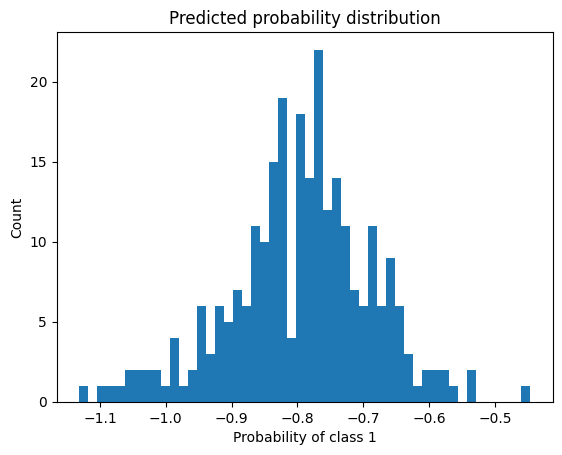

In [ ]:
y_pred_probs = model.predict(X_test_scaled)
plt.hist(y_pred_probs, bins=50)
plt.title("Predicted probability distribution")
plt.xlabel("Probability of class 1")
plt.ylabel("Count")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train.flatten())

y_pred_log = log_reg.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


[[63 70]
 [57 72]]
              precision    recall  f1-score   support

           0       0.53      0.47      0.50       133
           1       0.51      0.56      0.53       129

    accuracy                           0.52       262
   macro avg       0.52      0.52      0.51       262
weighted avg       0.52      0.52      0.51       262

